# REINFORCE in TensorFlow (3 pts)¶

This notebook implements a basic reinforce algorithm a.k.a. policy gradient for CartPole env.

It has been deliberately written to be as simple and human-readable.

Authors: [Practical_RL](https://github.com/yandexdataschool/Practical_RL) course team

In [1]:
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

The notebook assumes that you have [openai gym](https://github.com/openai/gym) installed.

In case you're running on a server, [use xvfb](https://github.com/openai/gym#rendering-on-a-server)

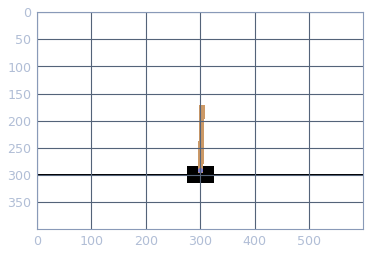

In [2]:
import gym
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make("CartPole-v0")

# gym compatibility: unwrap TimeLimit
if hasattr(env, 'env'):
    env = env.env

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

plt.imshow(env.render("rgb_array"))

# Building the network for REINFORCE

For REINFORCE algorithm, we'll need a model that predicts action probabilities given states.

For numerical stability, please __do not include the softmax layer into your network architecture__.
We'll use softmax or log-softmax where appropriate.

In [4]:
class PolicyApproximator(Model):
    def __init__(self, action_dim):
        super().__init__()
        self.d1 = Dense(16, activation='relu', name='dense1')
        self.d2 = Dense(32, activation='relu', name='dense2')
        self.d3 = Dense(32, activation='relu', name='dense3')
        self.d4 = Dense(16, activation='relu', name='dense4')
        self.d5 = Dense(2, activation=None)

    def call(self, x):
        x = tf.expand_dims(x, 0)
        x = self.d1(x)
        x = self.d2(x)
        x = self.d3(x)
        x = self.d4(x)
        return self.d5(x)

# Create an instance of the model
action_dim = env.action_space.n
policy_approximator = PolicyApproximator(action_dim=action_dim)

In [5]:
def policy(state):
    return tf.nn.softmax(policy_approximator(state))

def log_policy(state):
    return tf.nn.log_softmax(policy_approximator(state))

In [203]:
# utility function to pick action in one given state
def get_action_probs(s, pol):
    if pol == 'log_policy':
        action_probs = log_policy(s)
    elif pol == 'policy':
        action_probs = policy(s)
    return tf.squeeze(action_probs, 0)

### Playing the game

In [7]:
def generate_session(t_max=1000):
    """ 
    play a full session with REINFORCE agent and train at the session end.
    returns sequences of states, actions and rewards
    """

    # arrays to record session
    states, actions, rewards = [], [], []

    s = env.reset()

    for t in range(t_max):

        # action probabilities array aka pi(a|s)
        s = tf.Variable(s, name='state_' + str(t), dtype='float32')
        action_probs = get_action_probs(s, pol='policy').numpy().reshape(2,)
        # choose an action
        a = np.random.choice([0, 1], p=action_probs)
        # perform a step
        new_s, r, done, info = env.step(a)

        # record session history to train later
        states.append(s.numpy())
        actions.append(a)
        rewards.append(r)

        s = new_s
        if done:
            break
            
    return states, actions, rewards

### Computing cumulative rewards

In [160]:
def get_cumulative_rewards(rewards,  # rewards at each step
                           gamma=0.99  # discount for reward
                           ):
    """
    take a list of immediate rewards r(s,a) for the whole session 
    compute cumulative rewards R(s,a) (a.k.a. G(s,a) in Sutton '16)
    R_t = r_t + gamma*r_{t+1} + gamma^2*r_{t+2} + ...

    The simple way to compute cumulative rewards is to iterate from last to first time tick
    and compute R_t = r_t + gamma*R_{t+1} recurrently

    You must return an array/list of cumulative rewards with as many elements as in the initial rewards.
    """
    cumulative_returns = np.zeros(len(rewards))
    G = 0
    for i in range(len(rewards) - 1, -1, -1):
       # print("i step is {} now".format(i))
       # print('The reward after action A_{} is {}'.format(i+1, rewards[i]))
        G = gamma * G + rewards[i]
        cumulative_returns[i] = G
       # print('The return after action  A_{} is {}'.format(i+1, com_returns[i]))
    

    
    
    return cumulative_returns

In [161]:
assert len(get_cumulative_rewards(range(100))) == 100
assert np.allclose(get_cumulative_rewards([0, 0, 1, 0, 0, 1, 0], gamma=0.9), [
                   1.40049, 1.5561, 1.729, 0.81, 0.9, 1.0, 0.0])
assert np.allclose(get_cumulative_rewards(
    [0, 0, 1, -2, 3, -4, 0], gamma=0.5), [0.0625, 0.125, 0.25, -1.5, 1.0, -4.0, 0.0])
assert np.allclose(get_cumulative_rewards(
    [0, 0, 1, 2, 3, 4, 0], gamma=0), [0, 0, 1, 2, 3, 4, 0])
print("looks good!")

looks good!


#### Loss function and updates

We now need to define objective and update over policy gradient.

Our objective function is

$$ J \approx  { 1 \over N } \sum  _{s_i,a_i} \pi_\theta (a_i | s_i) \cdot G(s_i,a_i) $$


Following the REINFORCE algorithm, we can define our objective as follows: 

$$ \hat J \approx { 1 \over N } \sum  _{s_i,a_i} log \pi_\theta (a_i | s_i) \cdot G(s_i,a_i) $$

When you compute gradient of that function over network weights $ \theta $, it will become exactly the policy gradient.


In [ ]:
def policy(state):
    return tf.nn.softmax(policy_approximator(state))

def log_policy(state):
    return tf.nn.log_softmax(policy_approximator(state))

In [ ]:
# utility function to pick action in one given state
def get_action_probs(s, pol):
    if pol == 'log_policy':
        action_probs = log_policy(s)
    elif pol == 'policy':
        action_probs = policy(s)
    return tf.squeeze(action_probs, 0)

In [273]:
# policy objective as in the last formula. please use mean, not sum.
# note: you need to use log_policy_for_actions to get log probabilities for actions taken.
def compute_objective(state, actions, cumulative_returns):
    action_probs = get_action_probs(state, pol='log_policy')
    action_taken = tf.reshape(tf.cast(actions, dtype='float32'), (state.shape[0], 1))
    J = tf.math.reduce_mean(tf.math.multiply(cumulative_returns, action_probs))
    return J

In [274]:
# Entropy
def entropy(state):
    return -tf.math.reduce_sum(tf.math.multiply(log_policy(state), policy(state)))

In [275]:
# Loss
def compute_loss(state, actions, cumulative_returns, entropy_coef):
    return - compute_objective(state, actions, cumulative_returns) - entropy_coef * entropy(state)

In [276]:
# Your code: define optimizers
optimizer = tf.keras.optimizers.Adam()

In [277]:
def train_on_session(states, actions, rewards, gamma=0.99, entropy_coef=1e-2):
    """
    Takes a sequence of states, actions and rewards produced by generate_session.
    Updates agent's weights by following the policy gradient above.
    Please use Adam optimizer with default parameters.
    """
    
    # Gradient descent step
    with tf.GradientTape() as tape:
        # cast everything into tensorflow tensors
        states = tf.Variable(states, dtype='float32', name='states')
        actions = tf.Variable(actions, dtype='int32', name='actions')
        cumulative_returns = get_cumulative_rewards(rewards, gamma)
        cumulative_returns = tf.reshape(tf.Variable(cumulative_returns, dtype='float32', name='cumulative_returns'), (cumulative_returns.shape[0], 1))

        # predict logits, probas and log-probas using an agent.
        #logits = policy_approximator(states)
        #probs = tf.nn.softmax(logits, -1)
        #log_probs = tf.nn.log_softmax(logits, -1)

        #assert all(isinstance(v, tf.Tensor) for v in [logits, probs, log_probs])
        "please use compute using torch tensors and don't use predict_probs function"

        # Compute loss here. Don't forgen entropy regularization with `entropy_coef` 
        loss = compute_loss(states, actions, cumulative_returns, entropy_coef)
    
    gradients = tape.gradient(loss, policy_approximator.trainable_variables)
    optimizer.apply_gradients(zip(gradients, policy_approximator.trainable_variables))        

    # technical: return session rewards to print them later
    return np.sum(rewards)

In [279]:
train_on_session(*generate_session())

18.0

In [280]:
global_rewards = []

for i in range(10000):

    rewards = train_on_session(*generate_session()) # generate new sessions
    global_rewards.append(rewards)
    
    if i % 100 == 0:
        print(np.mean(global_rewards[-100:]))

    if np.mean(rewards) > 300:
        print("You Win!")
        break

26.0
21.21
24.03
20.87
23.49
22.24
23.08
22.33
22.03
22.22
21.65
26.8
21.86
21.35
22.11


KeyboardInterrupt: 

In [234]:
env?

Type:        CartPoleEnv
String form: <CartPoleEnv<CartPole-v0>>
File:        ~/project/gym/gym/envs/classic_control/cartpole.py
Docstring:  
Description:
    A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum starts upright, and the goal is to prevent it from falling over by increasing and reducing the cart's velocity.

Source:
    This environment corresponds to the version of the cart-pole problem described by Barto, Sutton, and Anderson

Observation: 
    Type: Box(4)
    Num     Observation                 Min         Max
    0       Cart Position             -4.8            4.8
    1       Cart Velocity             -Inf            Inf
    2       Pole Angle                 -24 deg        24 deg
    3       Pole Velocity At Tip      -Inf            Inf
    
Actions:
    Type: Discrete(2)
    Num     Action
    0       Push cart to the left
    1       Push cart to the right
    
    Note: The amount the velocity that is reduc

### Results & video

In [ ]:
# record sessions
import gym.wrappers
env = gym.wrappers.Monitor(gym.make("CartPole-v0"),
                           directory="videos", force=True)
sessions = [generate_session() for _ in range(100)]
env.close()

In [ ]:
# show video
from IPython.display import HTML
import os

video_names = list(
    filter(lambda s: s.endswith(".mp4"), os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1]))  # this may or may not be _last_ video. Try other indices

In [ ]:
assert len(get_cumulative_rewards(range(100))) == 100
assert np.allclose(get_cumulative_rewards([0, 0, 1, 0, 0, 1, 0], gamma=0.9), [
                   1.40049, 1.5561, 1.729, 0.81, 0.9, 1.0, 0.0])
#assert np.allclose(get_cumulative_rewards(
#    [0, 0, 1, -2, 3, -4, 0], gamma=0.5), [0.0625, 0.125, 0.25, -1.5, 1.0, -4.0, 0.0])
#assert np.allclose(get_cumulative_rewards(
#    [0, 0, 1, 2, 3, 4, 0], gamma=0), [0, 0, 1, 2, 3, 4, 0])
print("looks good!")# That's all, thank you for your attention!